# Operator overloading in python

In [1]:
class Planet:
    def __init__(self, moons):
        self.moons = moons
    
    def __add__(self, newplanet):
        newmoons = self.moons + newplanet.moons
        return Planet(moons=newmoons)

In [2]:
p1 = Planet(['Gany', 'Titan'])
p2 = Planet(['phobo', 'dimo'])

In [3]:
p3 = p1+p2

In [4]:
p3.moons

['Gany', 'Titan', 'phobo', 'dimo']

# GPcore Tests

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try:
    restartkernel()
except:
    pass

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.append(os.path.abspath('..'))

from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




todo:
- set g with setup (N, a_s)
- set vmax from evolve
- movie save
- fov
- ring potential - edge states (set V?)
- timedependent v
- bdg
- 

In [2]:

omega = 10.

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e5
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 900 * 1e-6

In [381]:
1e6*lb

16.62274915510922

In [382]:
# g = 0

In [3]:
DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,1000,40, True, 0.3e8)

In [4]:
xrelax = x.copy()

# Rotini

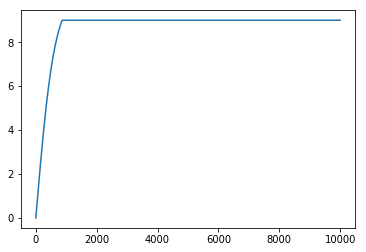

In [822]:
whirrMax = 0.9*omega

steps = 10000
times = np.arange(steps)
whirrtime = 1500

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(times, Omega)

In [823]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-3, False, 0.007)

gpcore.SetHarmonicPotential(omega,0.16) #omega, epsilon
gpcore.RotatingFrame(Omega)

gpcore.Evolve(x, steps, 50, True, 0.3e8)

In [758]:
# # back to circ
# steps = 3500
# Omega = whirrMax* np.ones(steps)
# gpcore.Setup(DIM, fov, g, 1e-3, False, 0.0001)

# gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
# gpcore.RotatingFrame(Omega)

# gpcore.Evolve(x, steps, 50, True, 1e8)

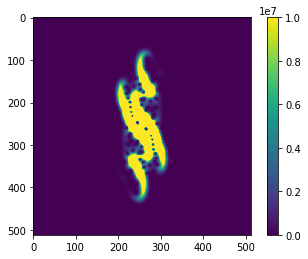

In [759]:
# plt.figure(figsize=(18,18))
plt.imshow(np.abs(x)**2, vmax=1e7)
plt.colorbar()

plt.show()

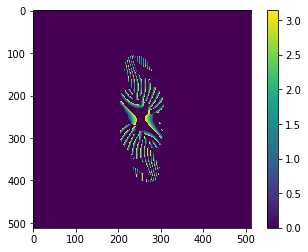

In [753]:
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e6), vmin=0)
plt.colorbar()

plt.show()

# epsilon-omega

In [40]:
from tqdm.notebook import tqdm
import pandas as pd

def compute_rotini(Omega=0.9, epsilon=0.16, steps=10000, show=False):
    whirrMax = Omega*omega
    times = np.arange(steps)
    whirrtime = 1500
    Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
    x = xrelax.copy()
    gpcore.Setup(DIM, fov, g, 1e-3, False, 0.007)
    gpcore.SetHarmonicPotential(omega,epsilon) #omega, epsilon
    gpcore.RotatingFrame(Omega)
    gpcore.Evolve(x, steps, 50, show, 0.3e8)
    out = x.copy()
    return out

In [54]:
Omegalist = [0.7,0.75,0.8, 0.85, 0.86,0.87, 0.88, 0.89, .9,0.91, .92, .94, .96, 1]
epsilonlist = [0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24]

In [55]:
columns = ['Omega', 'epsilon', 'steps', 'Psi']
results = pd.DataFrame(columns=columns)

for Omega in tqdm(Omegalist):
    for epsilon in tqdm(epsilonlist, leave=False):
        if Omega < 0.87:
            steps = 8000
        else:
            steps = 10000
        Psi = compute_rotini(Omega, epsilon, steps, True)
        newresults = pd.DataFrame([[Omega,epsilon,steps,Psi]],columns=columns)
        results = results.append(newresults,  ignore_index=True)

In [56]:
results.to_pickle('./epomega_1.pkl')

In [128]:
finalplot = []
view = 250
for i,r in results.iterrows():
    density = np.fliplr(np.abs(r.Psi)**2)
    finalplot.append(density[256-view//2 : 256+ view//2, 256-view//2 : 256+ view//2])

In [129]:
alls = np.reshape(finalplot, [len(Omegalist), len(epsilonlist), view, view])
last = np.hstack([np.vstack(alls[i,:,:,:]) for i in range(len(Omegalist))])

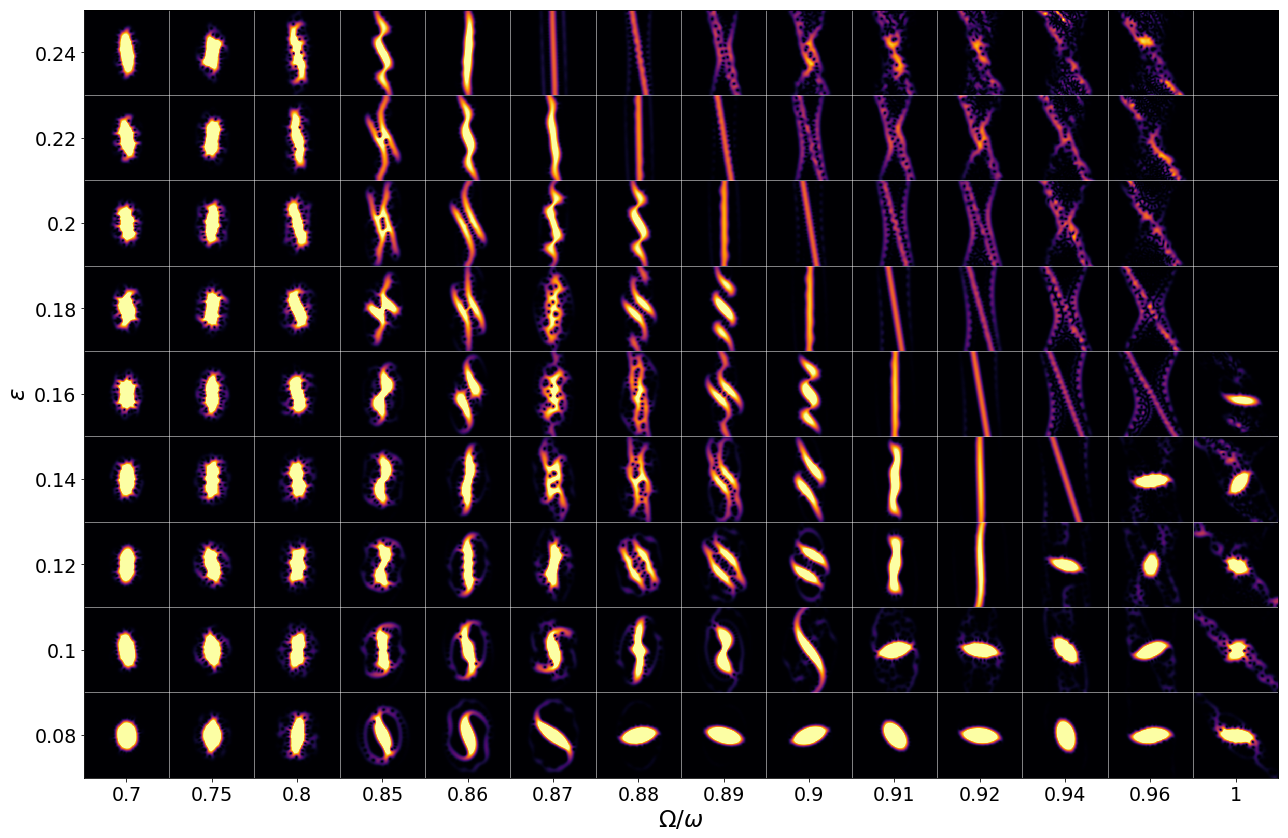

In [153]:
plt.figure(figsize=(18,18))
plt.imshow(last, cmap='inferno',origin='lower', vmax=5e7)
for i in range(len(Omegalist)):
    plt.axvline(i*view, color='w', lw=0.5)
for i in range(len(epsilonlist)):
    plt.axhline(i*view, color='w', lw=0.5)
plt.xticks(np.arange(view//2, len(Omegalist)*view, view), Omegalist) 
plt.yticks(np.arange(view//2, len(epsilonlist)*view, view), epsilonlist) 
plt.gca().tick_params(labelsize=19)
plt.xlabel('$\Omega/\omega$', size=23)
plt.ylabel('$\epsilon$', size=23)
plt.tight_layout()
plt.savefig('epsilon-omega.png')
plt.show()

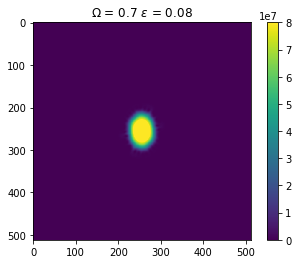

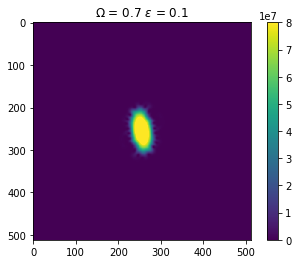

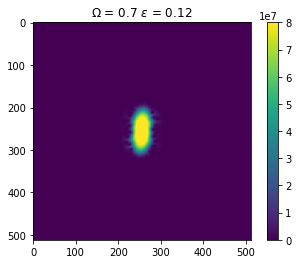

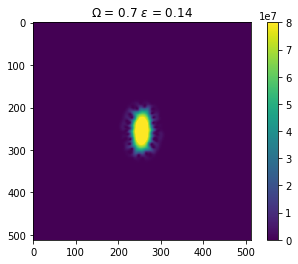

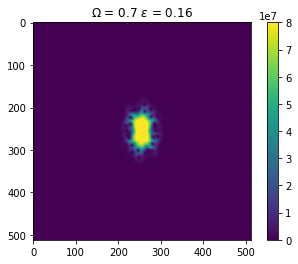

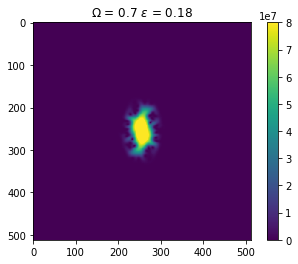

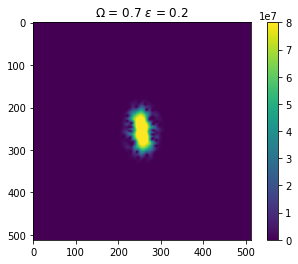

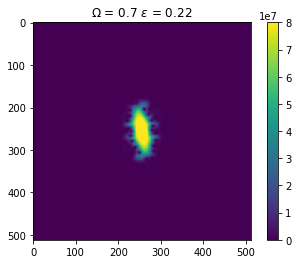

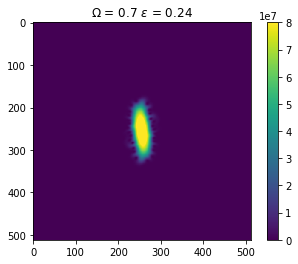

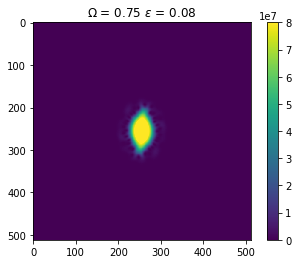

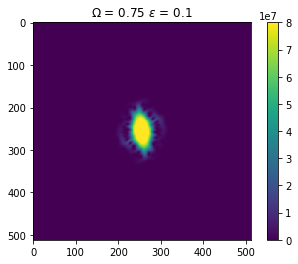

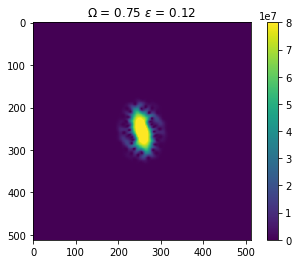

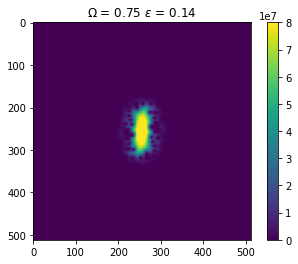

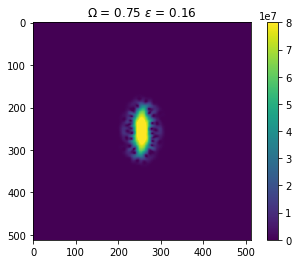

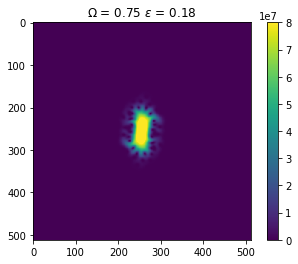

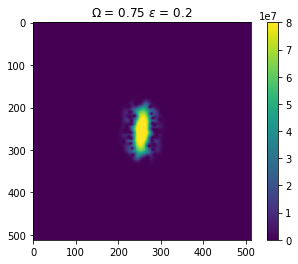

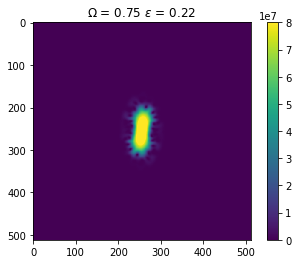

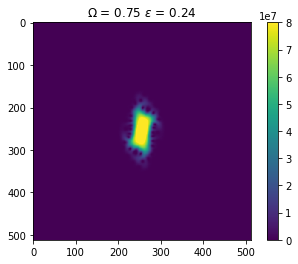

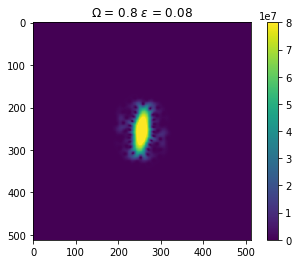

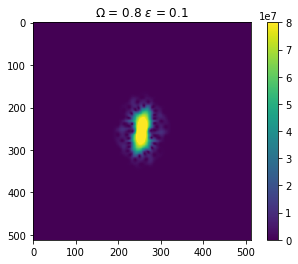

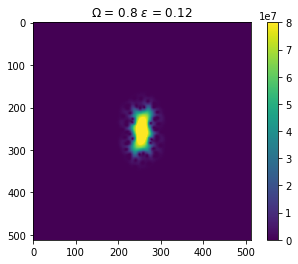

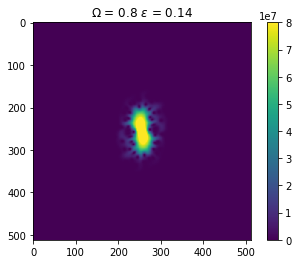

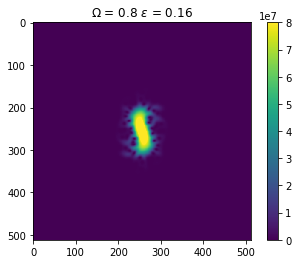

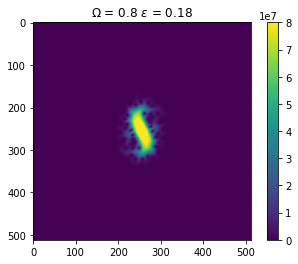

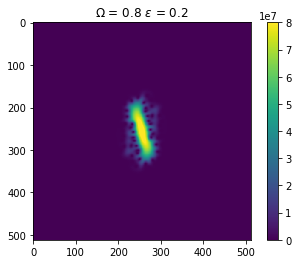

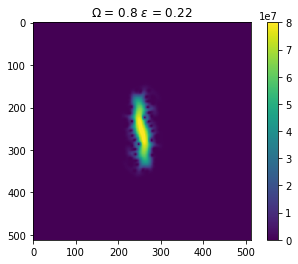

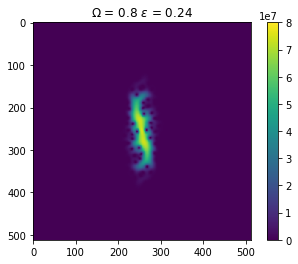

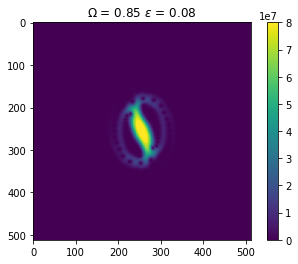

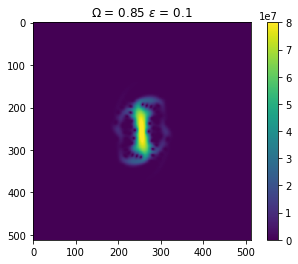

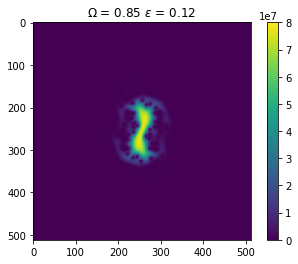

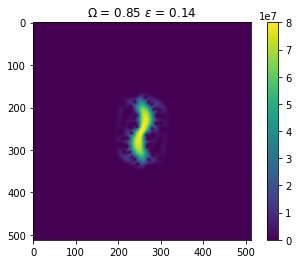

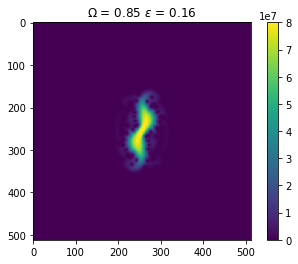

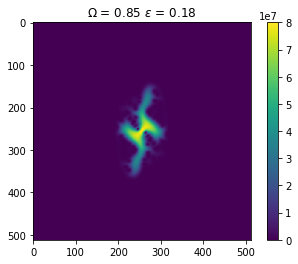

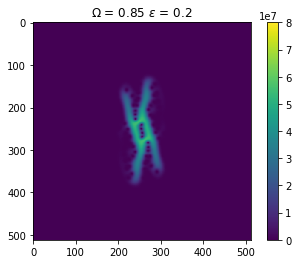

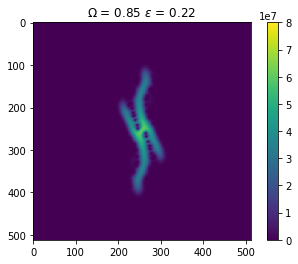

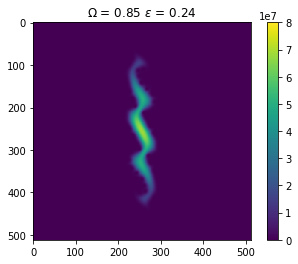

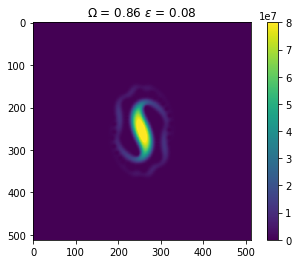

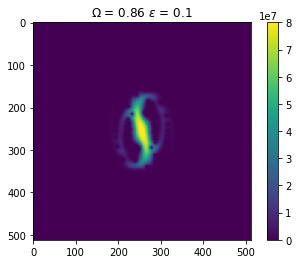

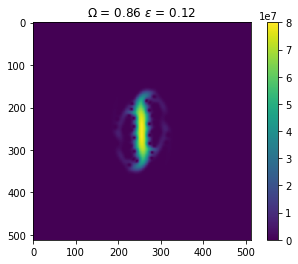

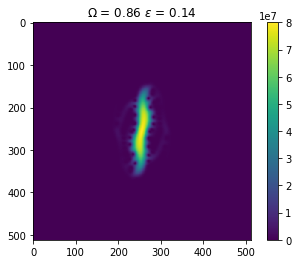

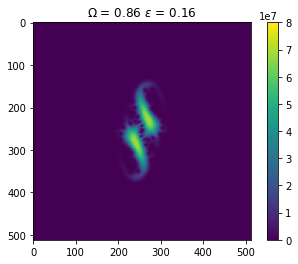

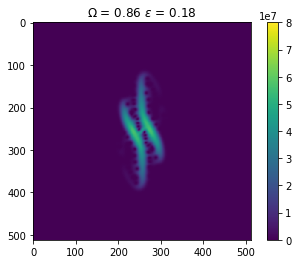

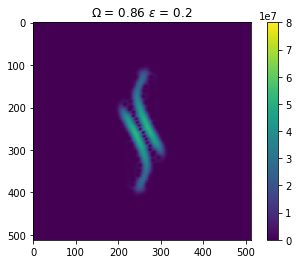

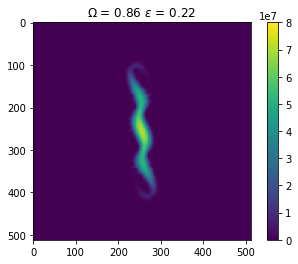

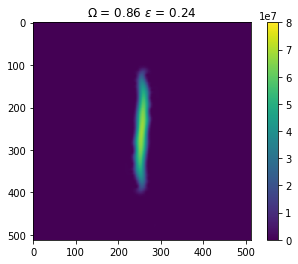

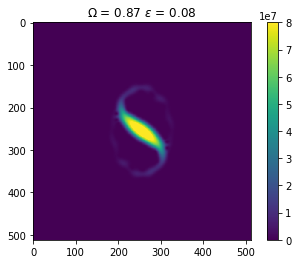

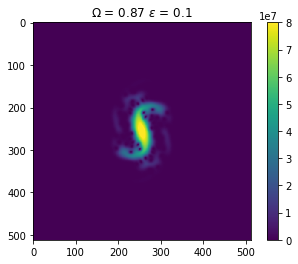

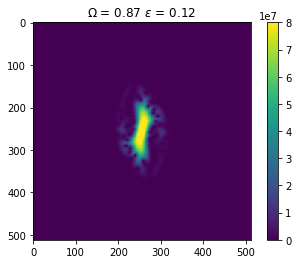

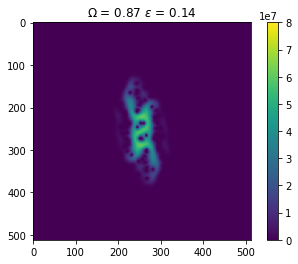

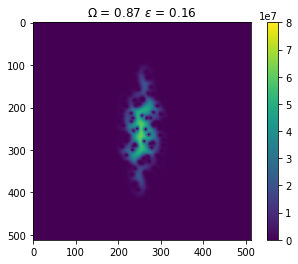

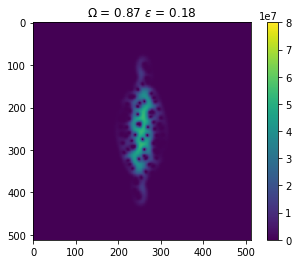

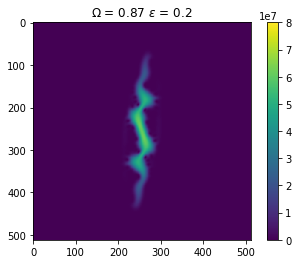

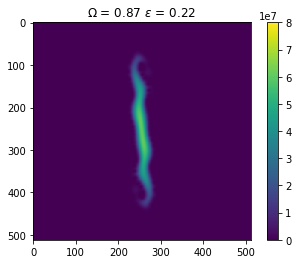

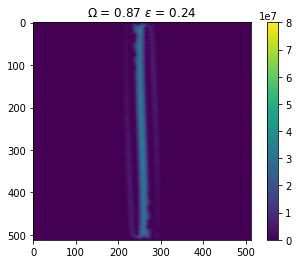

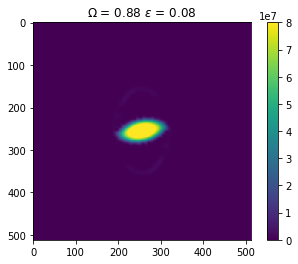

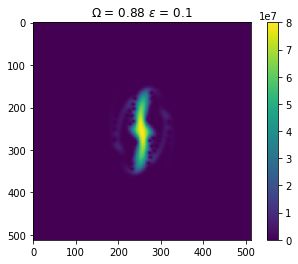

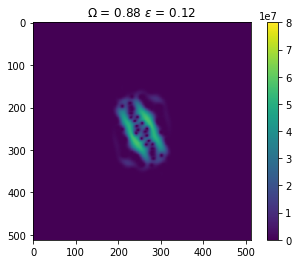

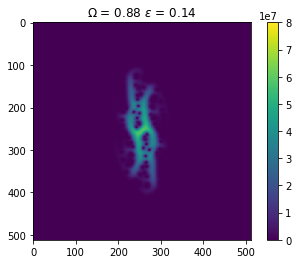

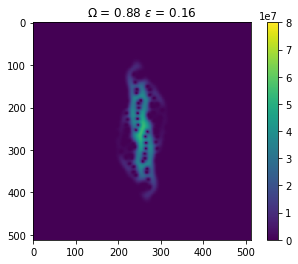

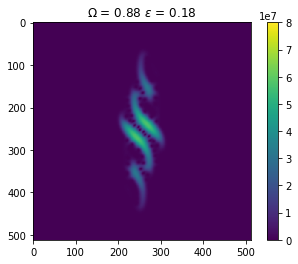

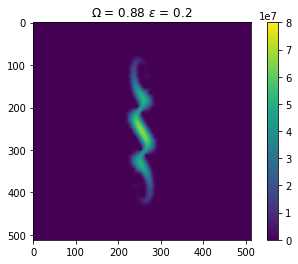

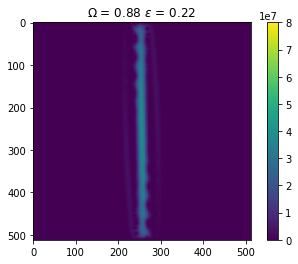

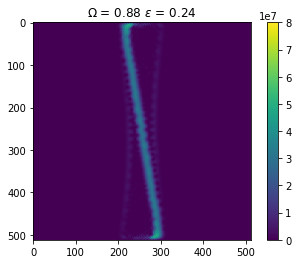

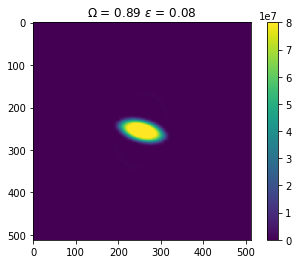

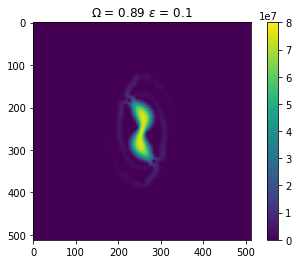

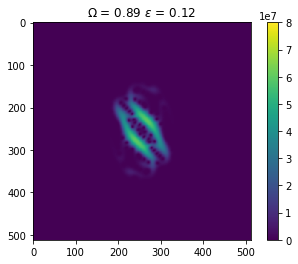

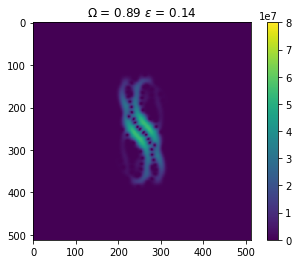

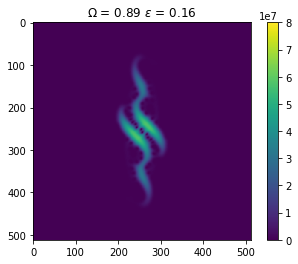

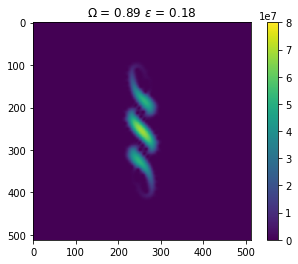

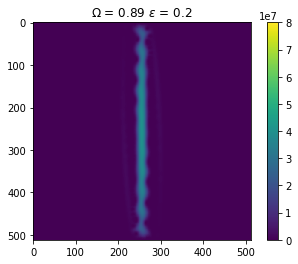

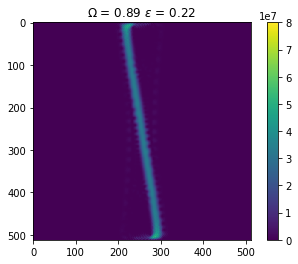

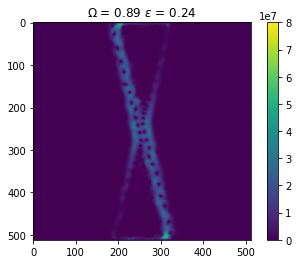

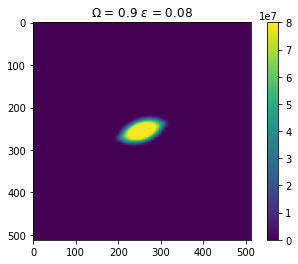

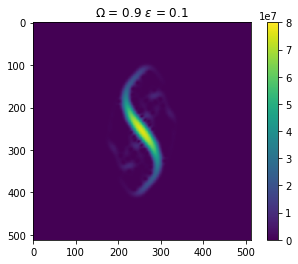

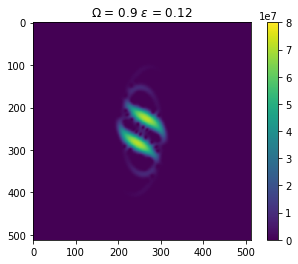

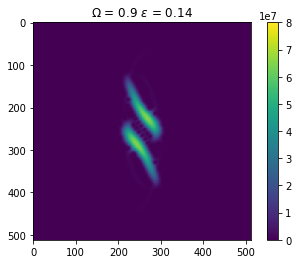

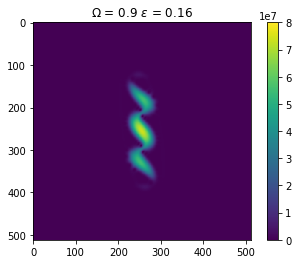

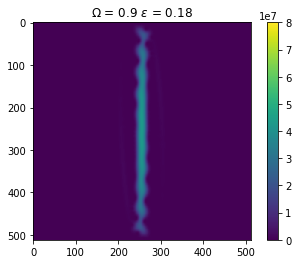

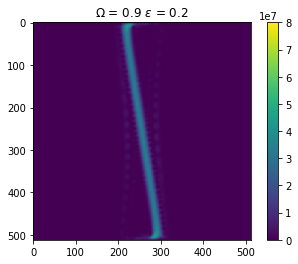

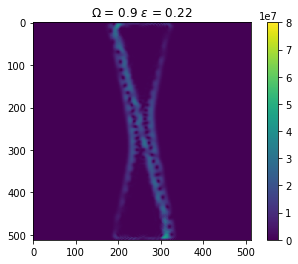

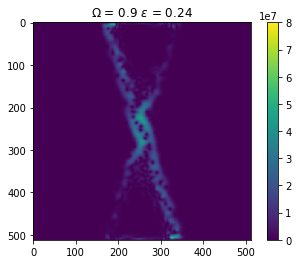

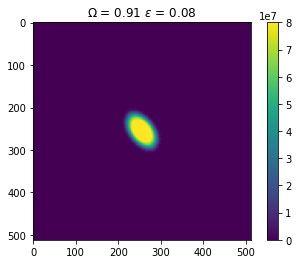

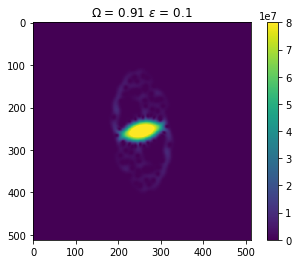

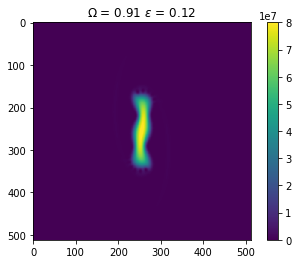

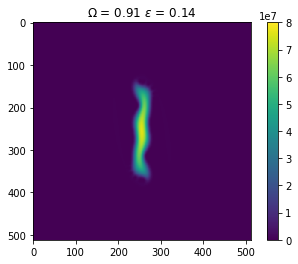

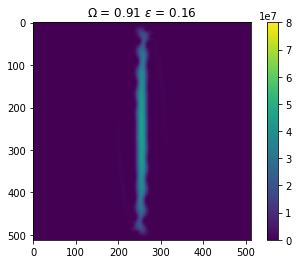

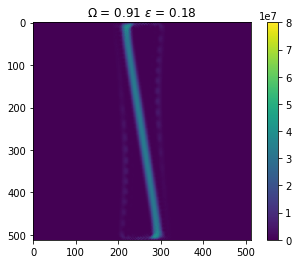

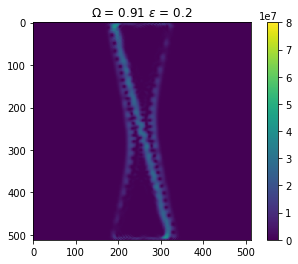

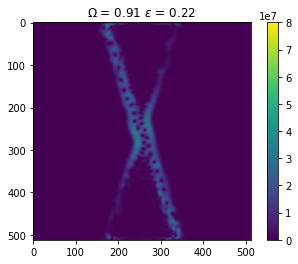

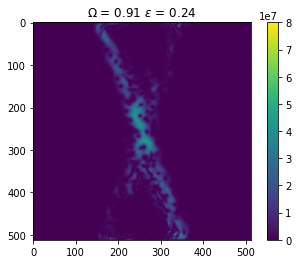

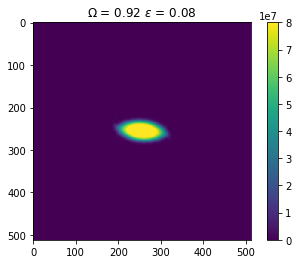

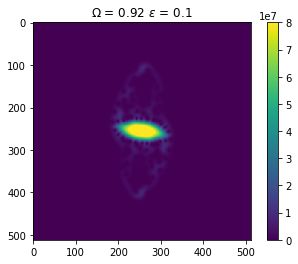

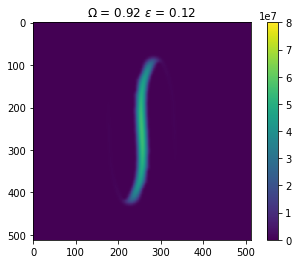

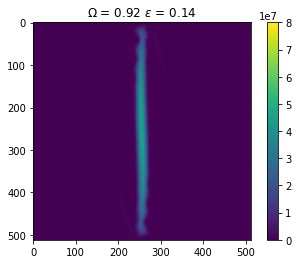

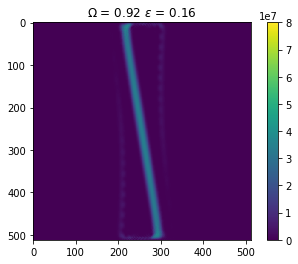

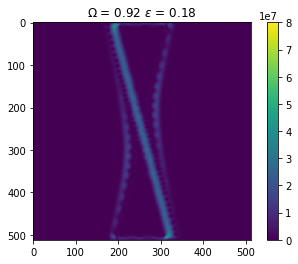

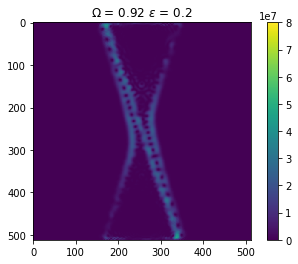

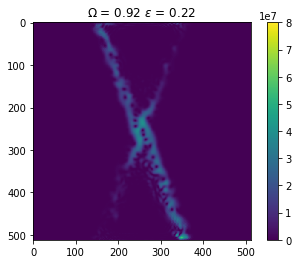

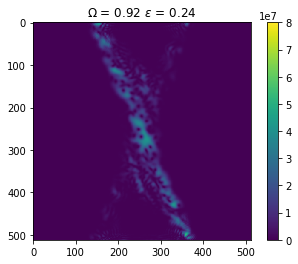

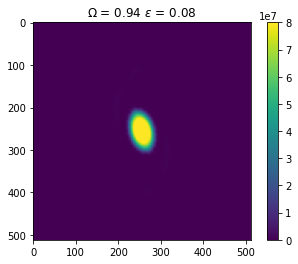

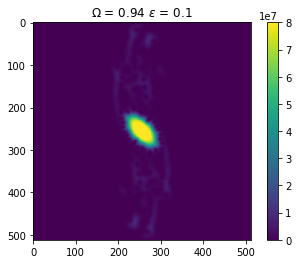

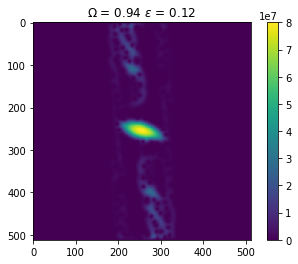

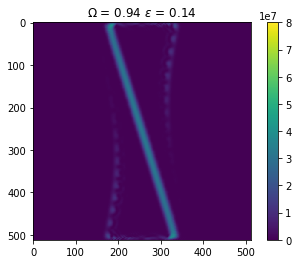

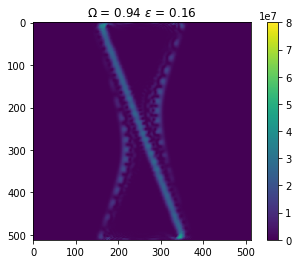

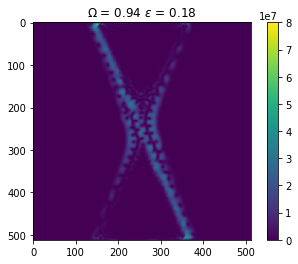

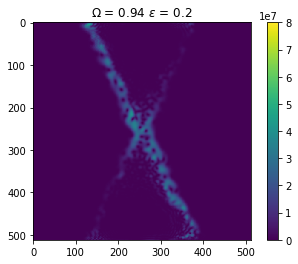

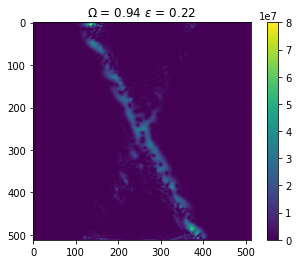

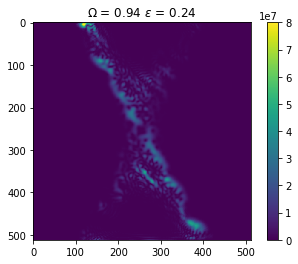

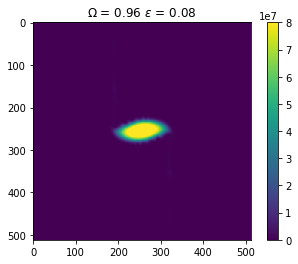

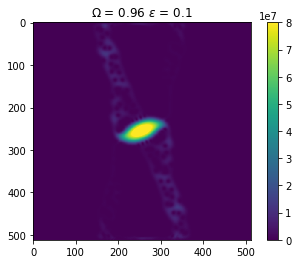

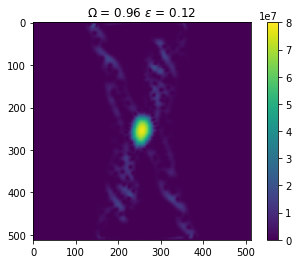

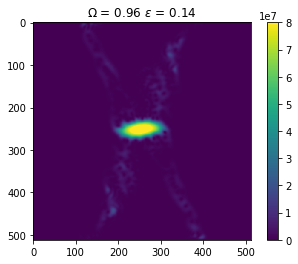

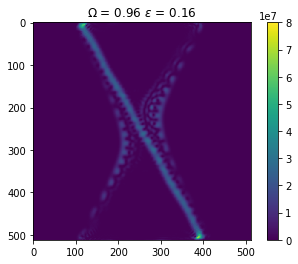

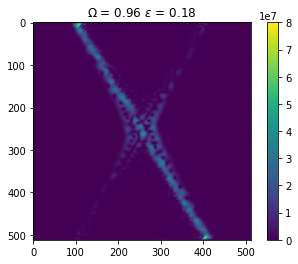

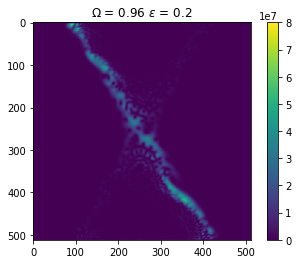

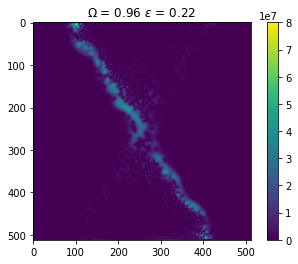

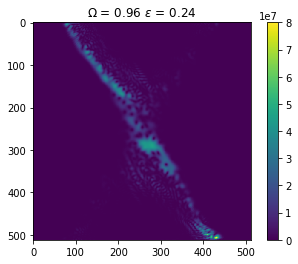

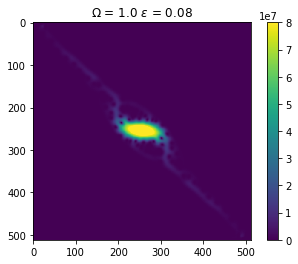

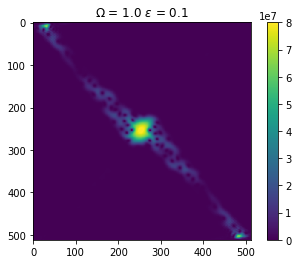

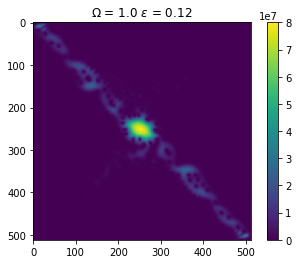

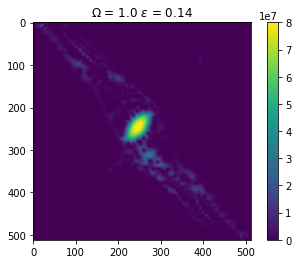

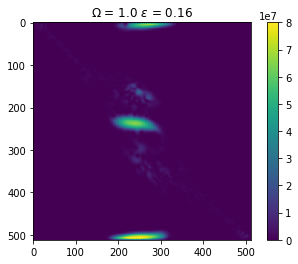

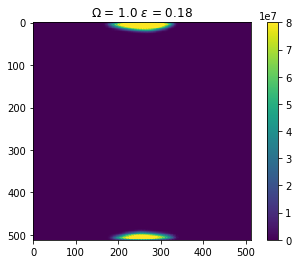

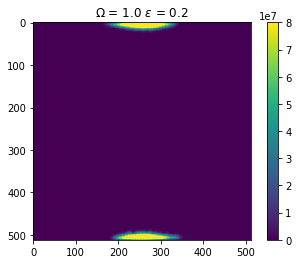

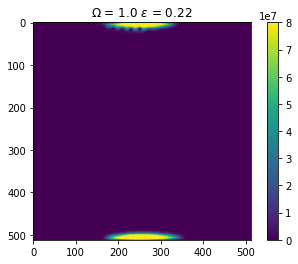

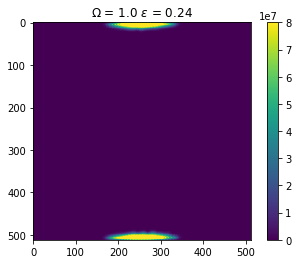

In [57]:
# plt.figure(figsize=(18,18))
for i,r in results.iterrows():
    plt.imshow(np.abs(r.Psi)**2, vmax=8e7)
    plt.colorbar()
    plt.title('$\Omega$ = '+str(r.Omega) + ' $\epsilon$ = ' + str(r.epsilon))

    plt.show()

In [6]:
gpcore.Setup(DIM, 1e-3, False, 0.001)

gpcore.SetHarmonicPotential(1,0.) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,20000,50, True)

TypeError: Setup() takes exactly 5 arguments (4 given)

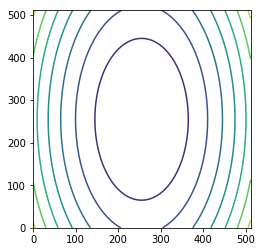

In [14]:
gpcore.Setup(DIM, g,1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(1,0.5) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,400,2, True)

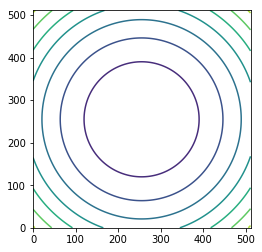

In [6]:
gpcore.Setup(DIM, 1e-3, False, 0.001)

gpcore.SetHarmonicPotential(1,0.) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,20000,50, True)

In [15]:
gpcore.Setup(DIM,g, 1e-3,  True, 0.001)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,200,4, True)

gpcore.Setup(DIM,g, 1e-1,  False, 0.001)
gpcore.SetHarmonicPotential(1,0.4) 
gpcore.Evolve(x,9,4, True)

gpcore.Setup(DIM,g, 1e-3,  False, 0.003)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,20000,50, True)

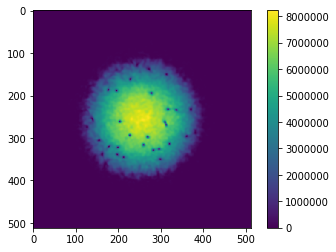

In [38]:
plt.imshow(np.abs(x)**2)
plt.colorbar()

plt.show()

In [39]:
xnew = x.copy()

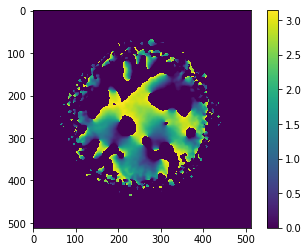

In [40]:
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

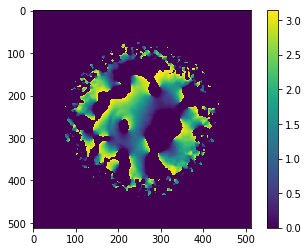

In [41]:
plt.imshow(np.angle(xold)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

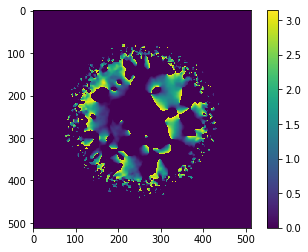

In [42]:
plt.imshow(np.angle(xold/xnew)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

In [7]:
dir(gpcore)

['Evolve',
 '__builtin__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_gpcore',
 '_newclass',
 '_object',
 '_swig_getattr',
 '_swig_property',
 '_swig_repr',
 '_swig_setattr',
 '_swig_setattr_nondynamic',
 'cvar',
 'getPotential',
 'setHarmonicPotential',
 'setup']

In [8]:
x = 500e-6
u = 1e-25 * (x**2)

In [10]:
u

2.4999999999999997e-36

## colormap interpolation

In [6]:
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit

def quad(x,a,b,c,d): return d + c*x + b * (x**2) + a * (x**3)

In [7]:
rgb = cm.get_cmap('inferno')
x = np.linspace(0,1,100)
colors = np.array([rgb(xx) for xx in x])

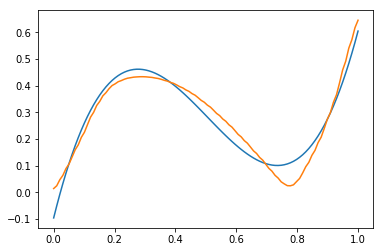

[  7.5327364  -11.43486921   4.60270604  -0.09628023]


In [8]:
channel = 2
f, _  = curve_fit(quad, x, colors[:,channel], [1,1,1,1])
plt.plot(x, quad(x, *f))
plt.plot(x,colors[:,channel])
plt.show()
print(f)